In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

## Import data

In [210]:
processed_base_dir = "../data/processed/"
raw_base_dir = "../data/raw/"

In [211]:
train_raw_filepath = raw_base_dir + "RAID0-train-8.csv"
test_raw_filepath = raw_base_dir + "RAID0-test-8.csv"
train_decimal_filepath = processed_base_dir + "RAID0-train-8-decimal.csv"
test_decimal_filepath = processed_base_dir + "RAID0-test-8-decimal.csv"

In [212]:
train_raw_df = pd.read_csv(train_raw_filepath, header = None)
test_raw_df = pd.read_csv(test_raw_filepath, header = None)
train_decimal_df = pd.read_csv(train_decimal_filepath)
test_decimal_df = pd.read_csv(test_decimal_filepath) 

In [213]:
train_raw_df.head()

,0,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,159,160
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,0,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


In [214]:
test_decimal_df.head()

,target,pending_1,pending_2,pending_3,pending_4,ebusy
0,8687,11474,56372,20520,46907,0
1,53256,58794,34686,41640,5882,0
2,59580,17895,6851,49390,61901,0
3,18324,60898,58978,5064,2740,0
4,10377,55376,26699,59662,1112,0


In [215]:
def get_X_y(df, mode = "raw"):
    #'''
    #df : dataframe
    #returns X,y
    #'''
    
    X = []
    y = []
    if mode == "decimal":
        X = df.iloc[:,:5].values
        y = df.iloc[:,5].values
    else:
        X = df.iloc[:,:160].values
        y = df.iloc[:,160].values
    return X,y

In [216]:
X_raw, y_raw = get_X_y(train_raw_df)
X_test_raw, y_test_raw = get_X_y(test_raw_df)
X_decimal, y_decimal = get_X_y(train_decimal_df, "decimal")
X_decimal, y_decimal = get_X_y(test_decimal_df, "decimal")

## Cross validation and Upsampling

In [217]:
figure_base_dir = "../reports/figures/"

In [218]:
def plot_auc_curve(y_true, prediction):
    fpr, tpr, threshold = roc_curve(y_true, prediction)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig(figure_base_dir+"raw_DTC_roc_curve.png")
    plt.show()

In [219]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(figure_base_dir+"raw_DTC_confusion_matrix.png")
    plt.show()

In [220]:
def accuracy_summary(y_true, y_pred):
    print("Accuracy : {}".format(accuracy_score(y_pred=prediction, y_true=y_true)))
    print("Precision : {}".format(precision_score(y_pred=prediction, y_true=y_true)))
    print("Recall : {}".format(recall_score(y_pred=prediction, y_true=y_true)))

Cross validation with 33% validation data ratio

### Raw Binary Representation

In [221]:
X_raw_train, X_raw_val, y_raw_train, y_raw_val = train_test_split(X_raw, y_raw, test_size=0.33, random_state=1)

In [222]:
upsampler = SMOTE(random_state=1)
X_raw_train_upsampled, y_raw_train_upsampled = upsampler.fit_resample(X_raw_train , y_raw_train)

In [223]:
len(X_raw_train_upsampled)

123146

#### Grid search parameter

In [224]:
param_grid = {'max_depth': np.arange(3, 10), 'min_samples_split': np.arange(2,10)}

clf = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid)

clf.fit(X_raw_train_upsampled, y_raw_train_upsampled)

/home/adylan/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([3, 4, 5, 6, 7, 8, 9]), 'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [225]:
prediction = clf.best_estimator_.predict(X_raw_val)

#### Confusion Matrix

Confusion matrix, without normalization
[[21428  9051]
 [ 1685   836]]


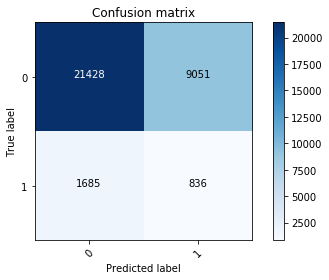

In [226]:
cnf_matrix = confusion_matrix(y_raw_val, prediction)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

#### ROC Curve

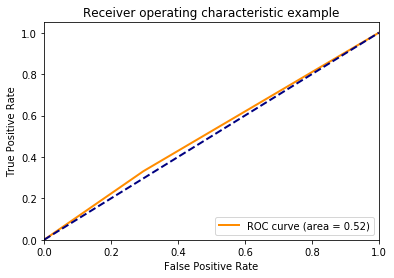

In [227]:
plot_auc_curve(y_raw_val, prediction)

#### Performance Summary

In [228]:
accuracy_summary(y_raw_val, prediction)

Accuracy : 0.6746666666666666
Precision : 0.08455547688884393
Recall : 0.33161443871479573


### Decimal Representation

In [229]:
X_decimal_train, X_decimal_val, y_decimal_train, y_decimal_val = train_test_split(X_decimal, y_decimal, test_size=0.33, random_state=1)

In [230]:
upsampler = SMOTE(random_state=2)
X_decimal_train_upsampled, y_decimal_train_upsampled = upsampler.fit_resample(X_decimal_train , y_decimal_train)

In [231]:
len(X_decimal_train_upsampled)

123306

#### Grid search hyper parameter

In [232]:
param_grid = {'max_depth': np.arange(3, 25), 'min_samples_split': np.arange(2,10)}

decimal_clf = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid)

decimal_clf.fit(X_decimal_train_upsampled, y_decimal_train_upsampled)

/home/adylan/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24]), 'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [233]:
decimal_prediction = decimal_clf.best_estimator_.predict(X_decimal_val)

#### Confusion Matrix

Confusion matrix, without normalization
[[17475 12858]
 [ 1510  1157]]


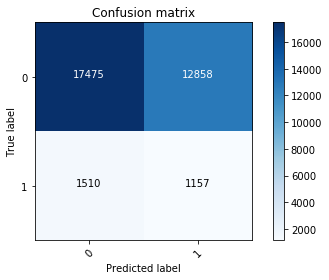

In [234]:
cnf_matrix = confusion_matrix(y_decimal_val, decimal_prediction)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

#### ROC Curve

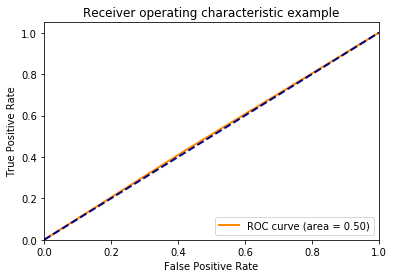

In [235]:
plot_auc_curve(y_decimal_val, decimal_prediction)

#### Performance Summary

In [236]:
accuracy_summary(y_decimal_val, decimal_prediction)

Accuracy : 0.6695151515151515
Precision : 0.08334176190957823
Recall : 0.3089613798275216
